# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [39]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [40]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [41]:
print_errors = False
build_new_dataset = False
symbol_list = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'
verticle_jobs = 1 #'-1' for max

## Data Preparation

In [42]:
if symbol_list == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbol_list == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'], dtype=object)

#### Download annual financial data

In [43]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan

            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
                
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'

            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]

            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]

            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]

            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1

                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 5:
                continue

            imputer = SimpleImputer()
            for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [44]:
df

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,AA,2024-12-31,NaN,NaN,NaN,Basic Materials,Aluminum,246000000.0,-2.166667e+08,-3.940000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-440000000.0,0.000000e+00,-7.200000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,2022-12-31,-0.062309,-0.250328,-0.243344,Basic Materials,Aluminum,342000000.0,-5.000000e+08,-1.000000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,530000000.0,-1.500000e+08,-1.294000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA,2020-12-31,0.398265,0.603471,1.574374,Basic Materials,Aluminum,169500000.0,-2.166667e+08,-4.402500e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,ZUMZ,2025-01-31,NaN,NaN,NaN,Consumer Cyclical,Apparel Retail,49699000.0,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5191,ZUMZ,2024-01-31,-0.002912,0.480489,-0.089691,Consumer Cyclical,Apparel Retail,-5595000.0,0.000000e+00,-4.944000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5192,ZUMZ,2023-01-31,-0.363531,-0.272938,-0.313202,Consumer Cyclical,Apparel Retail,-26006000.0,-8.786000e+07,-2.268800e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5193,ZUMZ,2022-01-31,-0.155506,-0.400445,-0.428254,Consumer Cyclical,Apparel Retail,119201000.0,-1.937890e+08,-2.480000e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Removal of low datapoint columns

In [ ]:
columns_to_remove = [col for col in df.columns if df[col].notna().sum() < 4000]

df = df.drop(columns=columns_to_remove)
print(columns_to_remove)
df

['Effect Of Exchange Rate Changes', 'Proceeds From Stock Option Exercised', 'Cash Dividends Paid', 'Preferred Stock Dividend Paid', 'Common Stock Dividend Paid', 'Net Investment Purchase And Sale', 'Sale Of Investment', 'Purchase Of Investment', 'Capital Expenditure Reported', 'Change In Other Current Liabilities', 'Change In Other Current Assets', 'Change In Accrued Expense', 'Change In Account Payable', 'Change In Tax Payable', 'Change In Income Tax Payable', 'Change In Prepaid Assets', 'Change In Inventory', 'Depreciation', 'Pension And Employee Benefit Expense', 'Earnings Losses From Equity Investments', 'Gain Loss On Investment Securities', 'Minority Interest', 'Preferred Stock', 'Other Non Current Liabilities', 'Derivative Product Liabilities', 'Employee Benefits', 'Non Current Pension And Other Postretirement Benefit Plans', 'Tradeand Other Payables Non Current', 'Non Current Deferred Liabilities', 'Non Current Deferred Revenue', 'Long Term Capital Lease Obligation', 'Long Term 

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Selling General And Administration,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue,Change In Other Working Capital,Interest Paid Supplemental Data,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale
0,AA,2024-12-31,NaN,NaN,NaN,Basic Materials,Aluminum,246000000.0,-2.166667e+08,-3.940000e+08,...,80000000.0,7.720000e+08,2.714000e+09,3.486000e+09,3.486000e+09,8.933333e+07,NaN,NaN,NaN,NaN
1,AA,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-440000000.0,0.000000e+00,-7.200000e+07,...,226000000.0,7.380000e+08,9.813000e+09,1.055100e+10,1.055100e+10,8.933333e+07,NaN,NaN,NaN,NaN
2,AA,2022-12-31,-0.062309,-0.250328,-0.243344,Basic Materials,Aluminum,342000000.0,-5.000000e+08,-1.000000e+06,...,204000000.0,2.239000e+09,1.021200e+10,1.245100e+10,1.245100e+10,-1.520000e+08,NaN,NaN,NaN,NaN
3,AA,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,530000000.0,-1.500000e+08,-1.294000e+09,...,227000000.0,2.999000e+09,9.153000e+09,1.215200e+10,1.215200e+10,3.010000e+08,NaN,NaN,NaN,NaN
4,AA,2020-12-31,0.398265,0.603471,1.574374,Basic Materials,Aluminum,169500000.0,-2.166667e+08,-4.402500e+08,...,184250000.0,1.687000e+09,7.973000e+09,9.660000e+09,9.660000e+09,1.190000e+08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,ZUMZ,2025-01-31,NaN,NaN,NaN,Consumer Cyclical,Apparel Retail,49699000.0,0.000000e+00,0.000000e+00,...,80903000.0,1.010330e+08,1.781270e+08,2.791600e+08,2.791600e+08,NaN,NaN,NaN,NaN,-4992000.0
5191,ZUMZ,2024-01-31,-0.002912,0.480489,-0.089691,Consumer Cyclical,Apparel Retail,-5595000.0,0.000000e+00,-4.944000e+07,...,345679000.0,2.808900e+08,5.945960e+08,8.754860e+08,8.754860e+08,NaN,NaN,NaN,NaN,-20350000.0
5192,ZUMZ,2023-01-31,-0.363531,-0.272938,-0.313202,Consumer Cyclical,Apparel Retail,-26006000.0,-8.786000e+07,-2.268800e+07,...,293578000.0,3.246780e+08,6.337020e+08,9.583800e+08,9.583800e+08,NaN,NaN,NaN,NaN,-25627000.0
5193,ZUMZ,2022-01-31,-0.155506,-0.400445,-0.428254,Consumer Cyclical,Apparel Retail,119201000.0,-1.937890e+08,-2.480000e+05,...,298920000.0,4.567300e+08,7.271370e+08,1.183867e+09,1.183867e+09,NaN,NaN,NaN,NaN,-15749000.0


### Impution and encoding

In [46]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [47]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Train and Test Data:')
display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Selling General And Administration,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue,Change In Other Working Capital,Interest Paid Supplemental Data,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale
0,0,2024-12-31,NaN,NaN,NaN,0,5,-0.018462,0.062248,0.060830,...,-0.071831,-5.198089e-02,-0.082475,-0.073132,-0.073837,-4.769806e-02,0.000000,0.000000,0.000000,0.000000
5,1,2024-12-31,NaN,NaN,NaN,8,94,-0.018670,0.000000,0.060917,...,-0.071922,-5.222010e-02,-0.083274,-0.073777,-0.074495,-4.779352e-02,-0.049932,0.000000,0.000000,0.000000
10,2,2025-01-31,NaN,NaN,NaN,7,120,-0.018803,0.070910,0.060836,...,-0.071717,-1.039262e-17,0.000000,-0.073394,-0.074104,-4.778237e-02,-0.050179,0.021578,0.065651,0.066395
15,3,2024-12-31,NaN,NaN,NaN,8,98,-0.018646,0.071855,0.060022,...,-0.071855,-1.039262e-17,0.000000,-0.073769,-0.074487,8.057143e-18,-0.047607,0.000000,0.000000,0.000000
20,4,2024-12-31,NaN,NaN,NaN,6,74,-0.016703,0.057888,0.060758,...,-0.068216,-5.018963e-02,-0.081809,-0.071700,-0.072376,-4.845279e-02,-0.039047,0.027898,0.074886,0.065674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5170,1034,2024-12-31,NaN,NaN,NaN,6,76,-0.018656,0.071855,0.060923,...,-0.071428,-5.209191e-02,-0.083149,-0.073625,-0.074340,-4.773643e-02,-0.049510,0.026452,0.064735,0.066414
5175,1035,2024-12-31,NaN,NaN,NaN,11,139,-0.018695,0.000000,0.060944,...,-0.071929,-5.223909e-02,-0.083285,-0.073795,-0.074513,8.057143e-18,-0.051062,0.000000,0.000000,0.066396
5180,1036,2024-12-31,NaN,NaN,NaN,1,66,-0.018615,0.071855,0.060800,...,-0.071499,-5.210077e-02,-0.083247,-0.073692,-0.074411,-4.779768e-02,-0.049809,0.027752,0.074671,0.066377
5185,1037,2024-12-31,NaN,NaN,NaN,9,24,-0.018423,0.070480,0.060946,...,-0.071604,-5.202312e-02,-0.083082,-0.073543,-0.074257,-4.772587e-02,-0.050020,0.018586,0.061280,0.066394


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Selling General And Administration,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue,Change In Other Working Capital,Interest Paid Supplemental Data,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale
1,0,2023-12-31,-0.018451,0.130405,0.123098,0,5,-0.019096,0.071855,0.060925,...,-0.071644,-0.051992,-0.080353,-0.071781,-0.072459,-4.769806e-02,0.000000,0.000000,0.00000,0.000000
2,0,2022-12-31,-0.062309,-0.250328,-0.243344,0,5,-0.018373,0.049685,0.060946,...,-0.071673,-0.051481,-0.080233,-0.071417,-0.072088,-4.795292e-02,0.000000,0.000000,0.00000,0.000000
3,0,2021-12-31,0.522660,-0.246283,-0.231174,0,5,-0.018199,0.065204,0.060566,...,-0.071643,-0.051223,-0.080550,-0.071475,-0.072147,-4.747452e-02,0.000000,0.000000,0.00000,0.000000
4,0,2020-12-31,0.398265,0.603471,1.574374,0,5,-0.018533,0.062248,0.060817,...,-0.071698,-0.051669,-0.080903,-0.071951,-0.072633,-4.766673e-02,0.000000,0.000000,0.00000,0.000000
6,1,2023-12-31,-0.031142,-0.031311,0.220023,8,94,-0.018592,0.000000,0.060891,...,-0.071888,-0.052149,-0.083238,-0.073714,-0.074431,-4.779352e-02,-0.049816,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5189,1037,2020-12-31,0.279577,0.384279,0.554758,9,24,-0.018315,0.061978,0.060888,...,-0.070946,-0.051561,-0.082591,-0.072970,-0.073672,-4.774593e-02,-0.049791,0.018586,0.06128,0.066351
5191,1038,2024-01-31,-0.002912,0.480489,-0.089691,2,7,-0.018695,0.071855,0.060932,...,-0.071491,-0.052148,-0.083109,-0.073631,-0.074346,8.057143e-18,0.000000,0.000000,0.00000,0.066391
5192,1038,2023-01-31,-0.363531,-0.272938,-0.313202,2,7,-0.018714,0.067959,0.060939,...,-0.071558,-0.052133,-0.083097,-0.073615,-0.074330,8.057143e-18,0.000000,0.000000,0.00000,0.066386
5193,1038,2022-01-31,-0.155506,-0.400445,-0.428254,2,7,-0.018579,0.063262,0.060946,...,-0.071551,-0.052088,-0.083069,-0.073572,-0.074286,8.057143e-18,0.000000,0.000000,0.00000,0.066396


### Labeling

In [48]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Selling General And Administration,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue,Change In Other Working Capital,Interest Paid Supplemental Data,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale
4104,486,5,13,-0.018656,0.071571,0.059658,-0.061117,5.944475e-02,-0.079217,-0.078538,...,-0.071884,-1.039262e-17,0.000000,-0.073778,-0.074496,-4.779322e-02,-0.050715,0.027708,0.074607,0.066410
2781,899,0,70,-0.018377,0.069638,0.060917,-0.062286,5.936395e-02,-0.079077,-0.078505,...,-0.071330,-5.188835e-02,-0.082937,-0.073375,-0.074085,-4.782013e-02,-0.050746,0.027560,0.074129,0.066414
3891,407,5,13,-0.018619,0.071829,0.060284,-0.061717,5.944500e-02,-0.079316,-0.078685,...,-0.071860,-1.039262e-17,0.000000,-0.073771,-0.074489,8.057143e-18,-0.050291,0.034943,0.000000,0.066410
3956,428,5,13,-0.018272,0.000000,0.060418,-0.061564,5.940049e-02,-0.078470,-0.078435,...,-0.071474,-1.039262e-17,0.000000,-0.073647,-0.074363,8.057143e-18,-0.046910,0.027898,0.074354,0.066361
171,47,7,108,-0.021262,0.071855,0.060185,-0.061477,5.523604e-02,-0.079054,-0.078172,...,-0.071651,-5.191643e-02,-0.082771,-0.073285,-0.073993,-4.779409e-02,-0.036921,0.000000,0.000000,0.063496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887,404,5,13,-0.018427,0.071855,0.060555,-0.061808,7.094583e-18,-0.079279,-0.078598,...,-0.071646,-1.039262e-17,0.000000,-0.073678,-0.074394,-4.779790e-02,-0.049448,0.030786,0.074886,0.000000
5028,974,5,63,-0.018503,0.071494,0.059774,-0.061211,5.944398e-02,-0.079231,-0.078575,...,-0.071565,-1.039262e-17,0.000000,-0.073569,-0.074283,-4.764914e-02,-0.050329,0.028084,0.074580,0.066409
2272,724,8,101,-0.016318,0.071855,0.052803,-0.054200,7.094583e-18,-0.079210,-0.078483,...,-0.071756,-5.118220e-02,-0.083219,-0.073159,-0.073873,8.057143e-18,-0.040842,0.030193,0.074886,0.000000
246,76,2,9,-0.018399,0.033084,0.060827,-0.061987,5.906501e-02,-0.079308,-0.078648,...,-0.067773,-5.049629e-02,-0.076763,-0.068645,-0.069267,8.057143e-18,0.000000,0.022697,0.066576,0.065991


,3M Future Change,6M Future Change,1Y Future Change
4104,0.329040,0.388348,0.521295
2781,0.022679,-0.142967,-0.155526
3891,-0.063232,-0.073982,0.155315
3956,-0.052235,-0.139161,0.240945
171,0.229135,0.150855,0.200958
...,...,...,...
3887,-0.192143,-0.298854,-0.058196
5028,-0.063069,-0.216715,0.013881
2272,0.010022,-0.034096,-0.045457
246,0.092937,0.035049,0.145941


,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Selling General And Administration,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue,Change In Other Working Capital,Interest Paid Supplemental Data,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale
1426,448,2,6,-0.018376,0.054708,6.086687e-02,-6.220803e-02,0.059253,-0.079300,-0.078610,...,-7.151097e-02,-5.194410e-02,-0.082594,-0.073187,-0.073894,-4.779751e-02,-0.049726,0.027898,0.072375,0.066258
368,129,7,19,-0.018590,0.068308,6.089263e-02,-6.226204e-02,0.059372,-0.079295,-0.078619,...,-7.163668e-02,-5.210567e-02,-0.083077,-0.073587,-0.074301,-4.781267e-02,-0.050643,0.029525,0.074864,0.066330
962,282,7,19,-0.017934,0.054119,6.084336e-02,-6.228707e-02,0.059276,-0.079119,-0.078506,...,-7.113609e-02,-5.160834e-02,-0.082215,-0.072756,-0.073454,-4.776346e-02,0.000000,0.027381,0.074129,0.000000
2294,728,11,137,-0.018972,0.071203,6.087268e-02,-6.216629e-02,0.058678,-0.079344,-0.078697,...,-9.757668e-18,-5.191391e-02,-0.082794,-0.073298,-0.074017,8.057143e-18,-0.047525,0.027898,0.074751,0.000000
363,128,2,88,-0.017973,0.063834,6.094214e-02,-6.207849e-02,0.059194,-0.079252,-0.078539,...,-7.051145e-02,-5.145618e-02,-0.081464,-0.072191,-0.072877,-4.780011e-02,-0.049135,-0.002909,0.029642,0.066152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3896,408,5,13,-0.018662,0.071738,5.877549e-02,-6.032297e-02,0.059444,-0.079339,-0.078685,...,-7.187261e-02,-1.039262e-17,0.000000,-0.073782,-0.074500,-4.779354e-02,-0.050387,0.027898,0.074886,0.066409
4319,627,8,98,-0.018686,0.071852,8.955902e-18,-1.608036e-17,0.059447,-0.079359,-0.078714,...,-7.193183e-02,-1.039262e-17,0.000000,-0.073797,-0.074516,8.057143e-18,-0.051054,0.000000,0.000000,0.066412
1444,456,2,10,-0.023054,-0.131009,5.041985e-02,-5.192332e-02,0.041970,-0.064522,-0.062156,...,-6.157717e-02,-4.689315e-02,-0.050365,-0.049740,-0.049977,-4.773643e-02,0.034119,0.000000,0.000000,0.066335
1774,561,9,39,-0.018351,0.049519,6.021307e-02,-6.164343e-02,0.058589,-0.078302,-0.077585,...,-7.070924e-02,-5.152576e-02,-0.076129,-0.068818,-0.069436,-4.780367e-02,-0.047782,0.026091,0.071862,0.065793


,3M Future Change,6M Future Change,1Y Future Change
1426,0.126539,0.156797,0.447851
368,-0.201722,-0.343223,-0.402591
962,-0.037887,0.095595,0.342598
2294,0.036513,0.093552,0.261143
363,-0.188631,-0.234459,-0.150614
...,...,...,...
3896,0.153661,0.160741,0.678681
4319,0.186181,0.541702,0.180597
1444,0.388088,0.419548,0.396013
1774,0.121653,0.327728,0.848471


## Model Training

In [49]:
base_model = MLPRegressor()

param_grid = {
    'shuffle': [True], 
    'solver': ['adam'], 
    'learning_rate': ['adaptive'],
    'tol': [0.0001],
    'max_iter': [200],
    'alpha': [0.0001],
    'hidden_layer_sizes': [(500, 500), (1000, 1000), (2000, 2000)],
    'learning_rate_init': [0.001],
    'n_iter_no_change': [3, 6, 9]
}

grid_search = GridSearchCV(
    estimator=base_model, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=3, 
    n_jobs=3,
    verbose=verticle_jobs,
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model = grid_search.best_estimator_
print('Best Parameters:')
print(best_params)

model.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (2000, 2000), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 9, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001}


MLPRegressor(hidden_layer_sizes=(2000, 2000), learning_rate='adaptive',
             n_iter_no_change=9)

## Testing and benchmarking

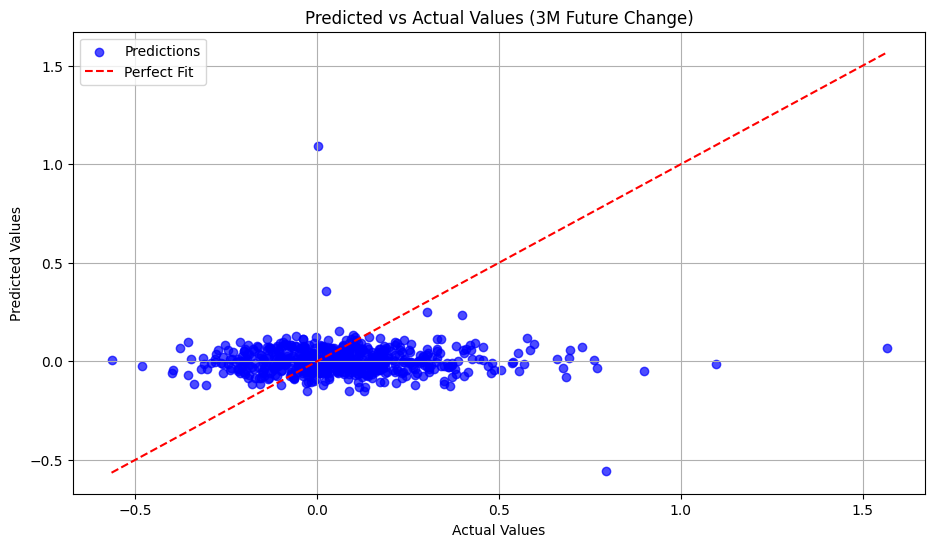

3M Future Change - R²: -0.2218
3M Future Change - MSE: 0.0556
3M Future Change - MAE: 0.1673


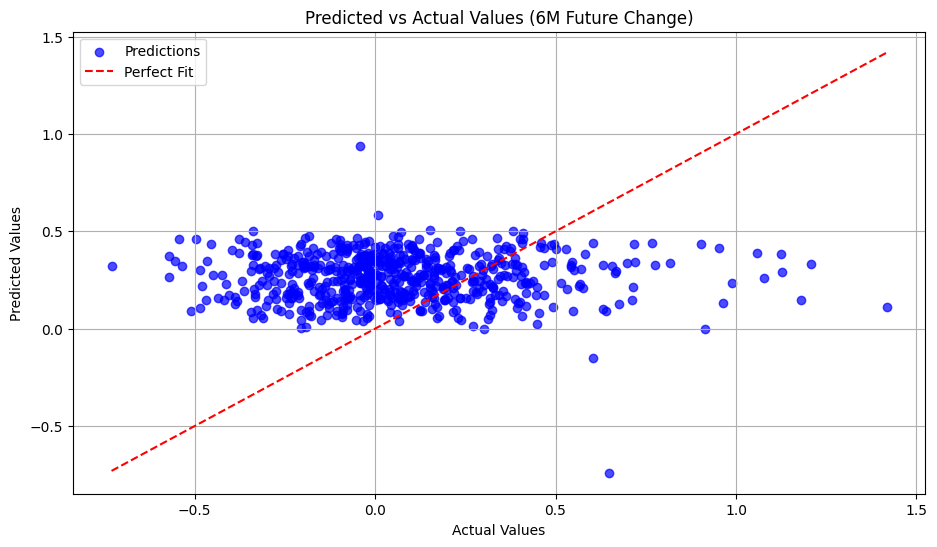

6M Future Change - R²: -0.6394
6M Future Change - MSE: 0.1427
6M Future Change - MAE: 0.3085


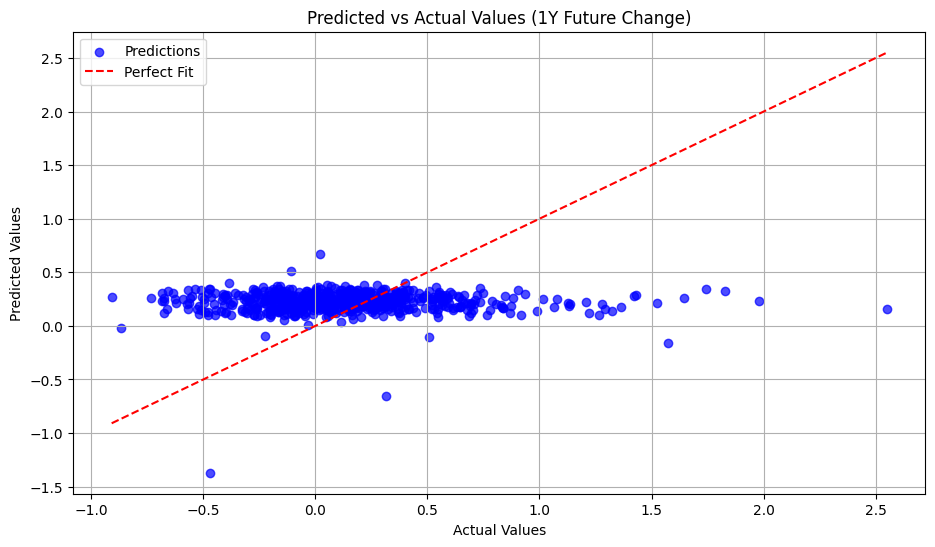

1Y Future Change - R²: -0.1104
1Y Future Change - MSE: 0.1935
1Y Future Change - MAE: 0.3337

Overall Scores:
Mean - R²: -0.3239
Mean - MSE: 0.1306
Mean - MAE: 0.2698


In [50]:
y_test_pred = model.predict(X_test)

for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
    y_test_actual = y_test[target]
    y_test_pred_target = y_test_pred[:, i]

    plt.figure(figsize=(11, 6))
    plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
    plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
        color='red', linestyle='--', label='Perfect Fit')
    plt.title(f'Predicted vs Actual Values ({target})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(y_test_actual, y_test_pred_target)
    mse = mean_squared_error(y_test_actual, y_test_pred_target)
    r2 = r2_score(y_test_actual, y_test_pred_target)

    print(f'{target} - R²: {r2:.4f}')
    print(f'{target} - MSE: {mse:.4f}')
    print(f'{target} - MAE: {mae:.4f}')

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('\nOverall Scores:')
print(f'Mean - R²: {r2:.4f}')
print(f'Mean - MSE: {mse:.4f}')
print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [51]:
test_results = pd.DataFrame({
    'R²': r2,
    'MSE': mse,
    'MAE': mae,
    'symbol_list': symbol_list,
    'hidden_layer_sizes': [model.hidden_layer_sizes],
    'max_iter': model.max_iter,
    'n_iter_no_change': model.n_iter_no_change,
    'learning_rate': model.learning_rate,
    'learning_rate_init': model.learning_rate_init,
    'batch_size': model.batch_size,
    'tol': model.tol,
    'alpha': model.alpha,
    'shuffle': model.shuffle,
})
test_results.to_csv('../data/test_results.csv', mode='a', index=False)

## Predictions on latest data